In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
import networkx as nx
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics.cluster import adjusted_rand_score
from pyclustertend import hopkins
from pyclustertend import vat, ivat
from matplotlib import pyplot as plt
sns.set()

In [535]:
#Load in data
os.chdir('/Users/Chase/Desktop/Capstone/datasets')
data = pd.read_csv("cap_final.csv")

We want to understand K-Means clustering of the congressional districts and check whether we can find any meaningful clustering structure in the data or not. We naively guess as a first assumption that because there is a clear, binary split of the districts into R or D and these each have a set of general demographics and characteristics that differ from each other, the data should cluster principally around these two categories, perhaps with some mixing, and we might expect offshoot clusters of each party alone or a mixture of the two when we increase the cluster number. We will implement PCA before the clustering to help determine the cluster structure better.

In our model, we use the 2014 and 2016 data to generate the clusters and then use the 2018 data to predict on the clusters found from the previous two years.  2018, 2016, or 2014 individual data can be selected by changing data['year'] to equal the desired year. We create a separate section for creating the 2018 dataset in the clustering section.

In [536]:
#Set your year here: (2014, 2016, or 2018) and clean data
data = data.loc[(data['year'] < 2018),:]
data = data.drop('Unnamed: 0', axis = 1)
data = data.dropna().reset_index()
data2 = data.copy()  #Use for later in analyzing clusters
data = data.drop(columns= ['district', 'abbreviation', 'index', 'state_dist', 'state', 'pct_won', 'rep_pct'])

In [537]:
#Check shape
data.shape

(870, 48)

In [538]:
data.head()

,party,year,laborforce_unemployed,PercentCar,PercentCarpool,PercentPublicTrans,Walked,Other_means,Management_business_science_and_arts,Service,...,U25k,r25k_50k,r50k_100k,r100k_200k,r200kplus,NoHighSchool,HighSchoolEd,SomeCollege,BachelorsOrHigher,dem_pct
0,R,2014,4.7,87.3,7.2,0.4,0.8,1.0,31.5,17.2,...,29.8,25.8,28.1,13.8,2.5,13.5,32.7,30.7,23.1,31.84
1,R,2014,5.2,85.1,9.0,0.4,1.2,1.3,31.6,17.3,...,30.2,27.3,27.6,12.8,2.0,16.4,32.4,29.5,21.6,32.66
2,R,2014,5.2,86.3,8.4,0.4,1.2,1.1,30.8,16.3,...,31.6,27.1,27.2,12.2,2.0,16.6,33.0,30.1,20.4,33.88
3,R,2014,4.1,86.1,9.6,0.3,0.8,0.6,28.1,17.1,...,33.4,26.8,27.7,10.5,1.5,19.3,35.1,29.3,16.3,1.43
4,R,2014,4.6,87.2,6.9,0.4,1.3,1.3,38.4,16.1,...,25.7,24.9,27.8,17.7,3.8,14.0,26.6,29.9,29.5,25.58


In [539]:
data = data.drop(columns = ['year'])

In [540]:
data.columns

Index(['party', 'laborforce_unemployed', 'PercentCar', 'PercentCarpool',
       'PercentPublicTrans', 'Walked', 'Other_means',
       'Management_business_science_and_arts', 'Service', 'Sales_and_office',
       'Natural_resources_construction_and_maintenance',
       'Production_transportation_and_material_moving',
       'Private_wage_and_salary_workers', 'Government_workers',
       'Less_than_10000', 'Median_household_income', 'No_health_insurance',
       'non_fam_household', 'college_enroll', 'vet_percent',
       'diff_house_1year', 'foreign_born', 'ForeignNotCit', 'ForeignCit',
       'home_lang_not_english', 'own_computer', 'total_pop', 'median_age',
       'white_pct', 'black_pct', 'amer_ind', 'asianpac', 'hispanic_pct',
       'PctU20', 'Pct20t45', 'Pct45t65', 'Pct65plus', 'U25k', 'r25k_50k',
       'r50k_100k', 'r100k_200k', 'r200kplus', 'NoHighSchool', 'HighSchoolEd',
       'SomeCollege', 'BachelorsOrHigher', 'dem_pct'],
      dtype='object')

### Standardize the data

In [541]:
#Standardize the Data
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(data.drop('party', 1))

### Principal component analysis


Since we have a high number of features, using PCA before proceeding to K-Means may separate the clusters better and find more structure in the data than if we only ran K-Means alone. We will then use the new principal components that are generated as the features when we run K-Means.

In [542]:
#Create PCA object and fit data
pca = PCA()
pca_fit = pca.fit(data_rescaled)
train = pd.DataFrame(pca.transform(data_rescaled))

In order to proceed with PCA, we can check how many principal components we want to keep and decide at a cutoff of how much variance we want to explain with the selected components. We will select 95% as our cutoff threshold and select only enough components to explain 95% of the variance in our data.

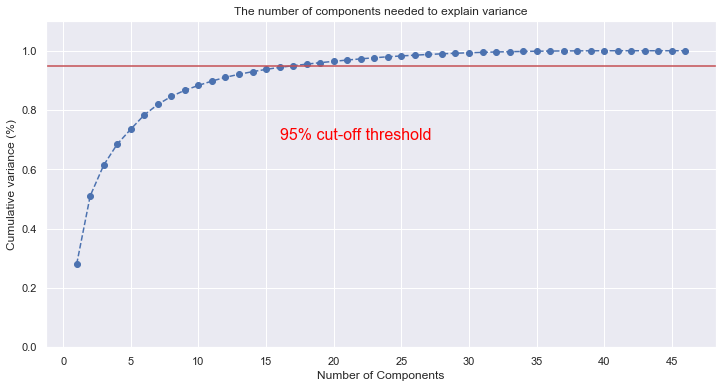

In [543]:
#Visualize PCA explained variance
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 47, step=1)
tot_exp_var = np.cumsum(pca_fit.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, tot_exp_var, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 46, step=5)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(16, 0.7, '95% cut-off threshold', color = 'red', fontsize=16)

#ax.grid(axis='x')
plt.show()

In [544]:
#How much did each additional component increase percent of explained variance?
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 28.05,  51.06,  61.44,  68.51,  73.54,  78.36,  81.89,  84.61,
        86.67,  88.31,  89.77,  91.05,  92.06,  92.95,  93.71,  94.4 ,
        94.95,  95.48,  95.98,  96.43,  96.87,  97.27,  97.65,  97.98,
        98.26,  98.52,  98.76,  98.98,  99.17,  99.34,  99.48,  99.6 ,
        99.69,  99.77,  99.84,  99.89,  99.93,  99.96,  99.98, 100.  ,
       100.  , 100.  , 100.  , 100.  , 100.  , 100.  ])

Based on the above plot, we will reduce our number of features from 46 original features to 17 principal components and use them for the clustering.

### Checking principal components

A major issue in cluster analysis is that the clustering methods will return clusters even when there are no meaningful clusters present because that is what it is supposed to do. We want to first check that there is some non-random structure to the data before proceeding to any clustering algorithms.

In [545]:
#Create subset of principal components using only first 17
pc_data = train.iloc[:,0:17]
pc_one = train[0]
pc_two = train[1]

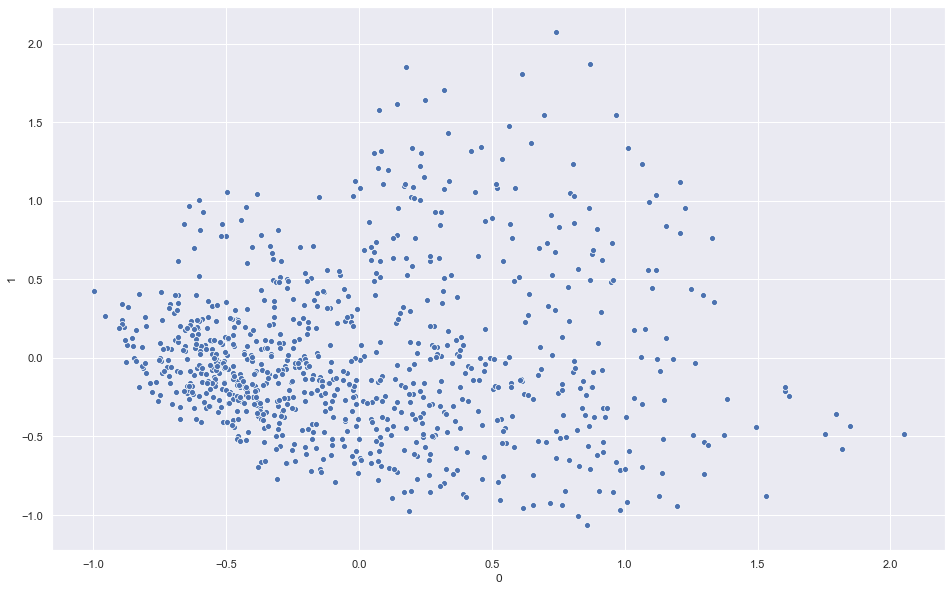

In [546]:
#Plot first two principal components
plt.figure(figsize=(16,10))
sns.scatterplot(
    x= pc_one, y=pc_two,
    #hue="time",
    palette=sns.color_palette("cubehelix", 10),
    #data=pc_df,
    legend="full",
    alpha=1
)

We see in the above plot that there appears to be some cluster structure in the bottom left corner of the plot when looking at only the first two principal components, although there are many other data points spread out on the righthand side. To further check the structure, we can use two metrics called the Hopkins statistic and iVat, which give a quantifiable measure for whether the data is uniform or not. The Hopkins Statistic test is used iteratively, with 0.5 as the threshold to reject the alternative hypothesis. That is, if H > 0.5, then it is unlikely that a dataset has statistically significant clusters.

In [527]:
#Hopkins score
hopkins(pc_data, 435)

0.190833272539401

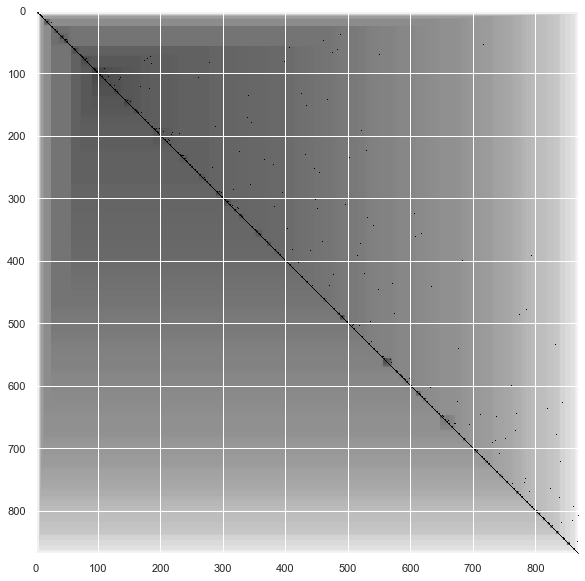

In [528]:
#Visual assessment of tendency (VAT) plot
ivat(pc_data)

We see based off the Hopkins score and the IVAT plot that there is some cluster structure present in the data that statistically differs from a completely uniform data distribution. Next, before jumping into the K-Means model, we will systematically check what the optimal number of clusters should be using the elbow method, silhouette method, and gap statistic method.

## Choosing the number of clusters

In K-Means, the algorithm clusters the data by attempting to separate the samples into k groups of equal variance, minimizing the inertia or within-cluster-sum-of-squares (WCSS). The choice of k must be input by hand in K-Means clustering, but we can estimate how many clusters to use by using the elbow method and silhouette analysis.

### Elbow method

Inertia is the sum of squared distances of points to their closest cluster center. The number of clusters should be chosen via the elbow method such that the inertia is not significantly improved by adding another cluster.

Text(0, 0.5, 'Inertia')

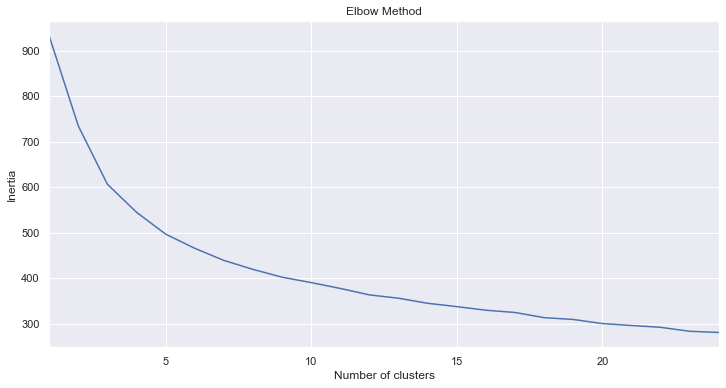

In [529]:
#Elbow Method
seed = 0
elbow = dict()
for k in range(1,25):
    estimator = KMeans(n_clusters = k,random_state=seed)
    res = estimator.fit_predict(pc_data)
    inertia = estimator.inertia_
    elbow[k] = inertia
    
elbow_df = pd.Series(elbow)
ax = elbow_df.plot(title = 'Elbow Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')

### Average silhouette method

Silhouette analysis plots a measure of how tightly grouped the samples in the clusters are. The silhouette coefficient is bounded in the range -1 to 1. If the silhouette coefficient is 0, then the cluster separation and cohesion are equal. We get close to the ideal silhouette coefficient of 1 if cluster separation greatly exceeds the cluster cohesion.

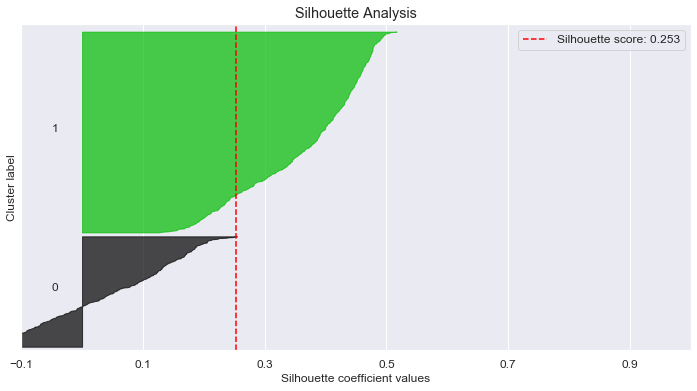

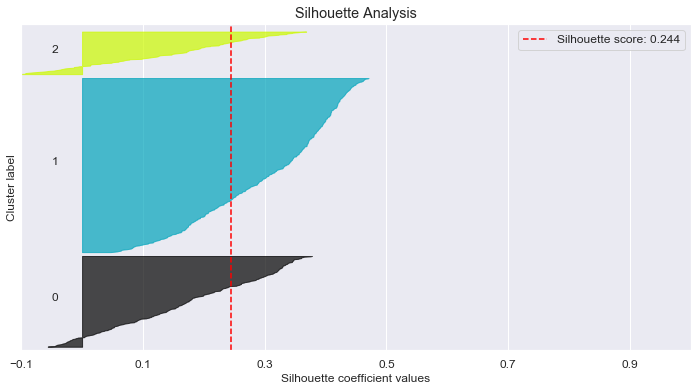

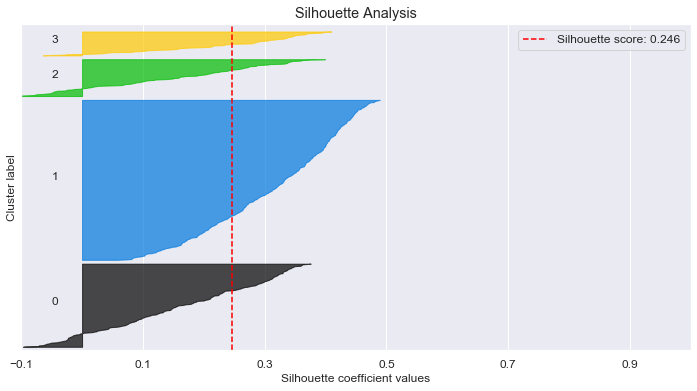

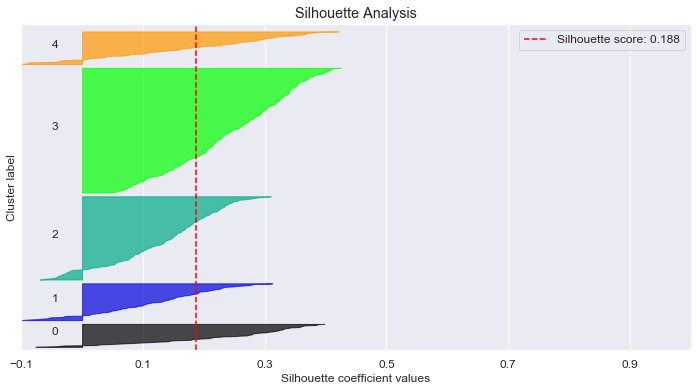

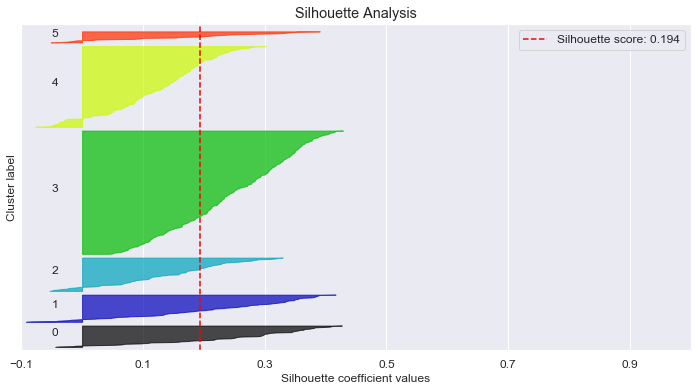

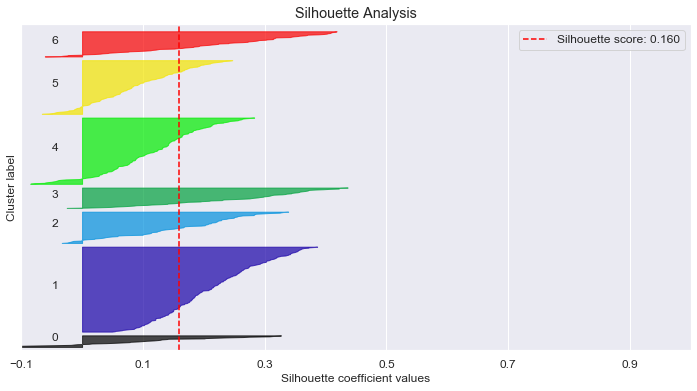

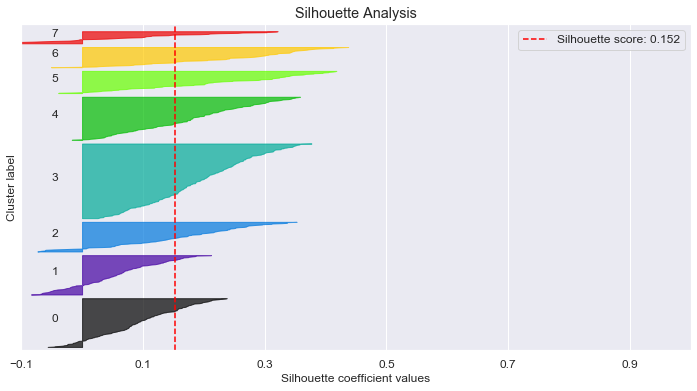

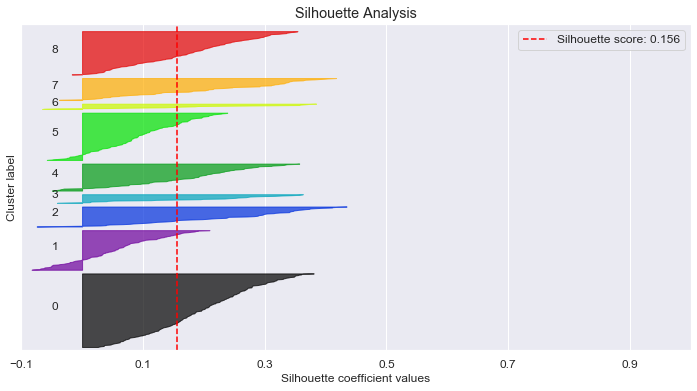

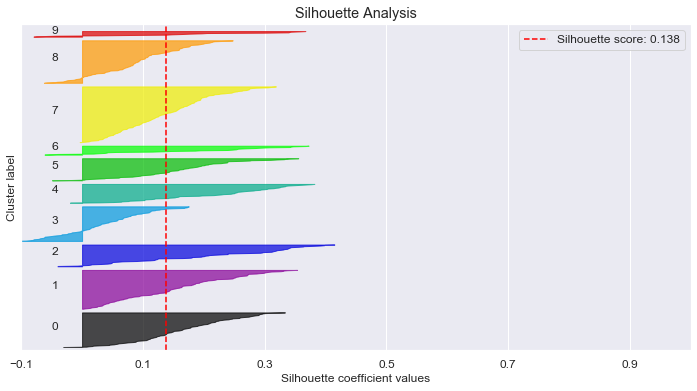

In [530]:
#Silhouette analysis for cluster size 2-10
for i in range(2,11):
    kmeans = KMeans(n_clusters=i, random_state=1)
    cluster_labels = kmeans.fit_predict(pc_data)
    skplt.metrics.plot_silhouette(pc_data, cluster_labels)
    plt.show()

## K-Means Clustering

As a first check, we can select k = 2 and plot the points using the principal components and see how they match the split of Repulican and Democrat districts.

In [547]:
#K-Means with k = 2
sns.set(rc={'figure.figsize':(11.7,8.27)})
km = KMeans(n_clusters=2, random_state=0)
km_clustering = km.fit(pc_data)

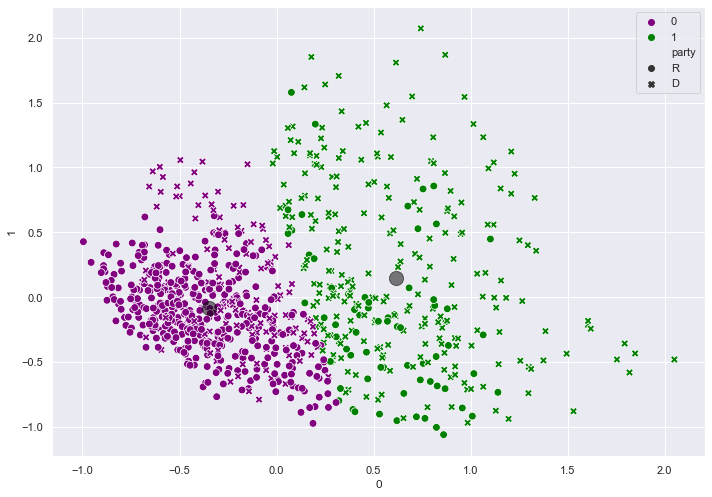

In [548]:
sns.scatterplot(pc_data.iloc[:,0], pc_data.iloc[:,1], 
                km_clustering.labels_, palette=['purple', 'green'], style = data.party, s =60)
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

We see for that case of k=2 that K-Means separates the majority of Republican and Democrat districts.

In [549]:
#K-Means with k = 3
sns.set(rc={'figure.figsize':(11.7,8.27)})
km = KMeans(n_clusters=3, random_state=0)
km_clustering = km.fit(pc_data)

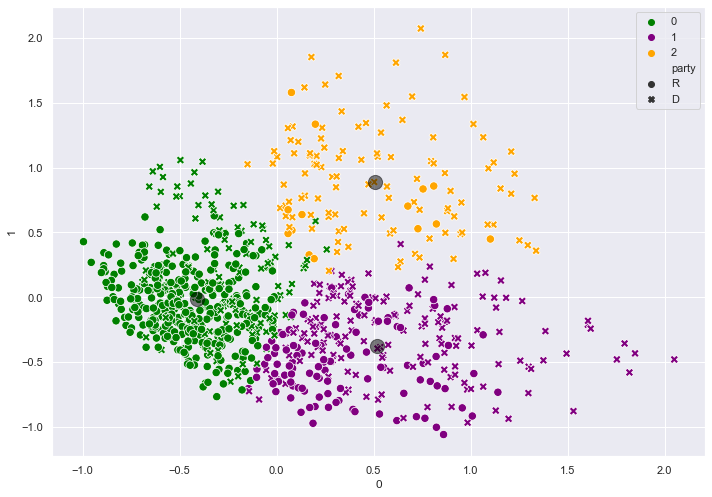

In [550]:
sns.scatterplot(pc_data.iloc[:,0], pc_data.iloc[:,1], 
                km_clustering.labels_, palette=['green', 'purple', 'orange'], style = data.party,s =70)
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [551]:
#K-Means with k = 4
sns.set(rc={'figure.figsize':(11.7,8.27)})
km = KMeans(n_clusters=4, random_state=0)
km_clustering = km.fit(pc_data)

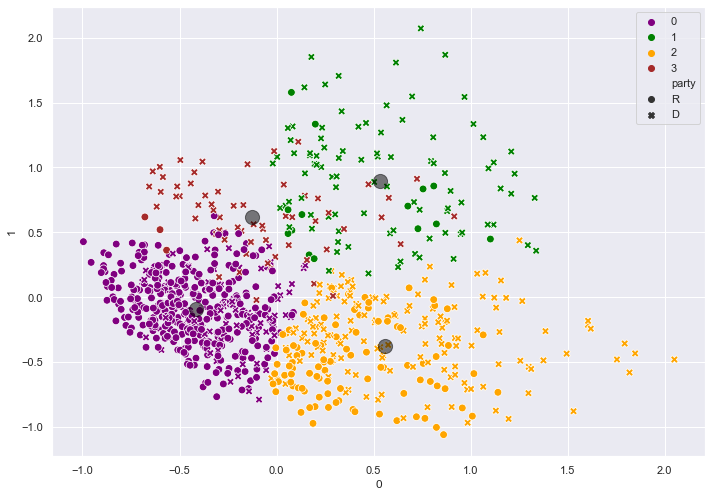

In [552]:
sns.scatterplot(pc_data.iloc[:,0], pc_data.iloc[:,1], 
                km_clustering.labels_, palette=['purple', 'green', 'orange', 'brown'],style = data.party,s =60)
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

It appears based on our clustering result for k=4 that the new clusters are mostly forming in Democrat districts and the Republican districts have a much higher similarity with each other.  We will now use the 2018 dataset to predict on the clusters that we have already generated using the 2014 and 2016 data.

In [574]:
#Reload dataset and create dataframe for 2018
data_new = pd.read_csv("cap_final.csv")
data2018 = data_new.loc[(data_new['year'] == 2018),:]
data2018 = data2018.drop('Unnamed: 0', axis = 1)
data2018 = data2018.dropna().reset_index()
data2018 = data2018.drop(columns= ['district', 'abbreviation', 'year','index', 'state_dist', 'state', 'pct_won', 'rep_pct'])

In [575]:
#Scale 2018 data
scaler = MinMaxScaler()
test_rescaled = scaler.fit_transform(data2018.drop('party', 1))

In [576]:
#PCA on 2018 data
pca = PCA(0.947)
pca.fit(test_rescaled)
test = pca.transform(test_rescaled)

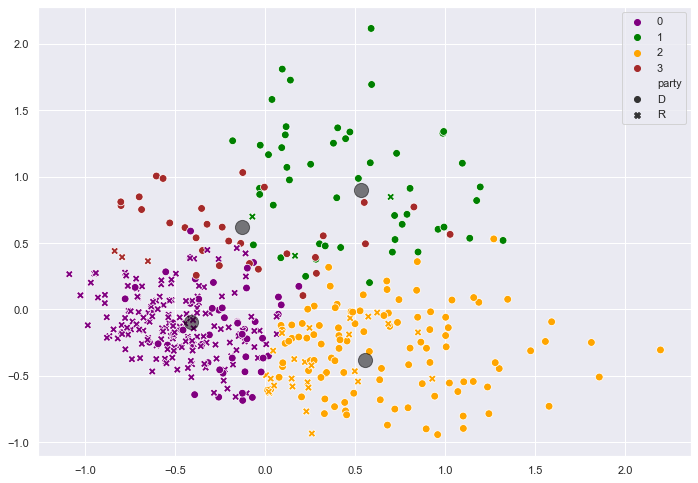

In [580]:
#Predict 2018 data using 2014 and 2016 cluster positions
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(test[:,0], test[:,1], 
                km_clustering.predict(test), palette=['purple', 'green', 'orange', 'brown'],style = data2018.party,s =60)
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

We can plot how much each principal component contributed to each cluster by looking at the cluster center values.

## Principal component importance by cluster

In [627]:
#Create a dataframe to plot the cluster PC values
clust_center = km.cluster_centers_
clusterdf=pd.DataFrame(clust_center).T
clusterdf.columns = ['cluster0', 'cluster1', 'cluster2', 'cluster3']
clusterdf['PC_Num'] = clusterdf.index + 1
clusterdf

,cluster0,cluster1,cluster2,cluster3,PC_Num
0,-0.413337,0.531846,0.556800,-0.128190,1
1,-0.092988,0.897466,-0.379965,0.620369,2
2,-0.030346,-0.306036,0.003802,0.684127,3
3,-0.010286,-0.090203,0.037929,0.072484,4
4,-0.017604,0.011415,0.018608,0.031772,5
5,0.047576,0.069504,-0.036481,-0.298927,6
6,-0.009093,0.013605,-0.002927,0.051145,7
7,-0.004204,-0.038296,0.024025,-0.000106,8
8,0.022837,0.017370,-0.034298,-0.054725,9
9,0.014373,-0.036561,-0.003324,-0.026788,10


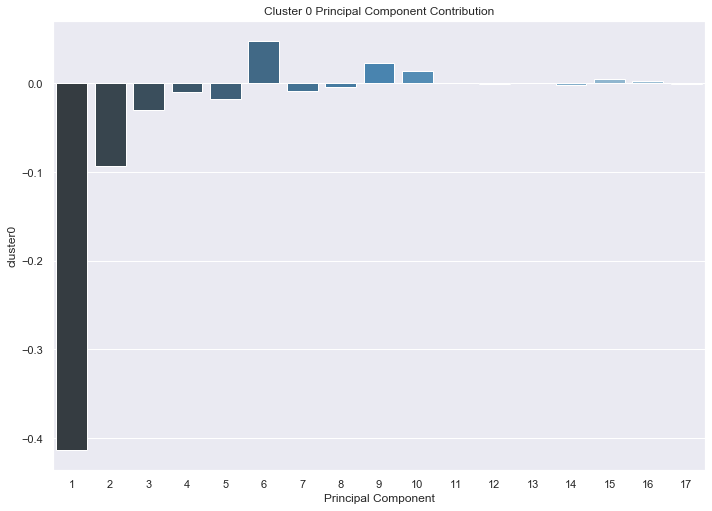

In [628]:
#Plot PC1
clusterdf['abs_0']=clusterdf['cluster0'].apply(lambda x: np.abs(x))
ax = sns.barplot(x='PC_Num', y='cluster0',palette="Blues_d", data=clusterdf.sort_values('abs_0', ascending=False).head(20))
ax.set_xlabel('Principal Component')
ax.set_title('Cluster 0 Principal Component Contribution')
plt.show()

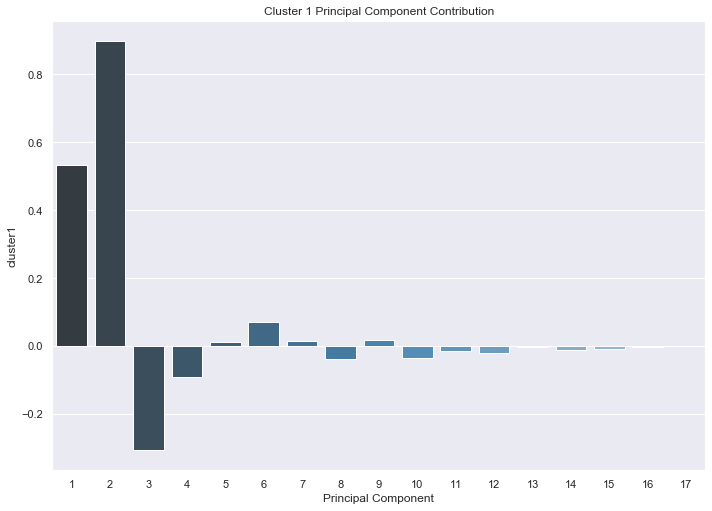

In [629]:
#Plot PC2 
clusterdf['abs_1']=clusterdf['cluster1'].apply(lambda x: np.abs(x))
ax = sns.barplot(x='PC_Num', y='cluster1',palette="Blues_d", data=clusterdf.sort_values('abs_1', ascending=False).head(20))
ax.set_xlabel('Principal Component')
ax.set_title('Cluster 1 Principal Component Contribution')
plt.show()

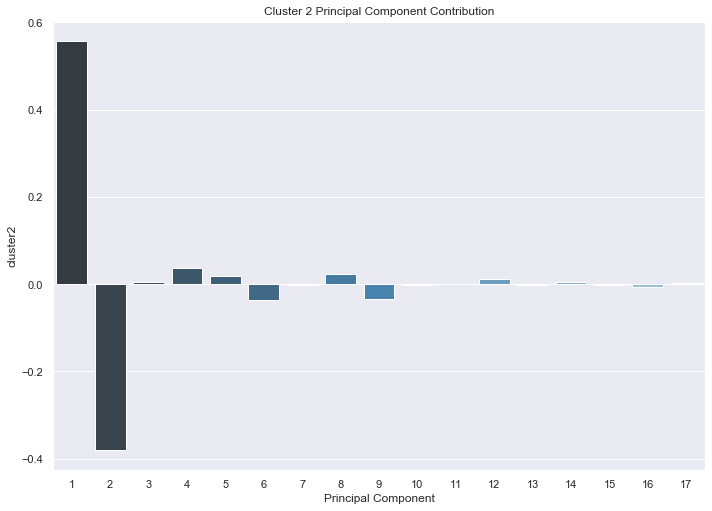

In [630]:
#Plot PC3
clusterdf['abs_2']=clusterdf['cluster2'].apply(lambda x: np.abs(x))
ax = sns.barplot(x='PC_Num', y='cluster2',palette="Blues_d", data=clusterdf.sort_values('abs_2', ascending=False).head(20))
ax.set_xlabel('Principal Component')
ax.set_title('Cluster 2 Principal Component Contribution')
plt.show()

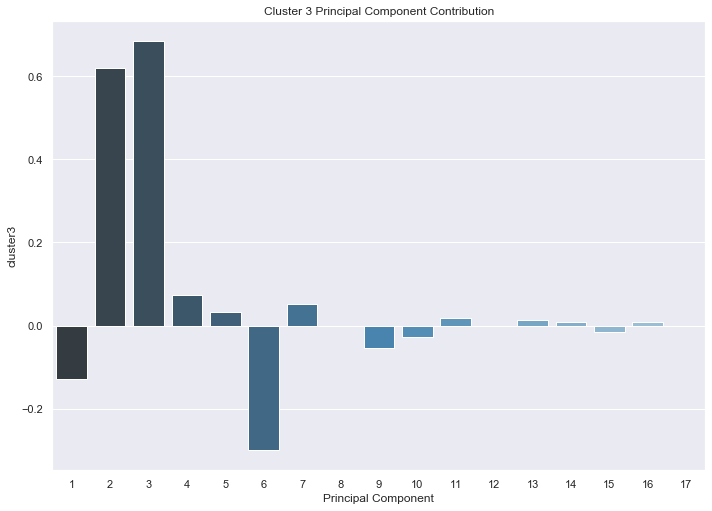

In [631]:
#Plot PC3
clusterdf['abs_3']=clusterdf['cluster3'].apply(lambda x: np.abs(x))
ax = sns.barplot(x='PC_Num', y='cluster3',palette="Blues_d", data=clusterdf.sort_values('abs_3', ascending=False).head(20))
ax.set_xlabel('Principal Component')
ax.set_title('Cluster 3 Principal Component Contribution')
plt.show()

After checking which principal components were most important in each cluster, we begin to see some patterns.

Cluster 0 is dominated negatively by the first principal component. Cluster 1 is a mix, most positively from the second principal component, but also from the first, and negatively affected by the third.  Cluster 2 is primarily receiving a positive contribution from the first principal component and negative contribution from the second.  Cluster 3 is dominated mostly positively by the second and third principal components.  We can now use this information to check which features were most positively or negatively represented in each of the first three principal components and draw conclusions about the general characteristics of the districts in each cluster.

In [587]:
#Create dataframe with cluster results and merge with dataframe
data2['cluster'] = km.labels_

In [499]:
#Filter data2 by cluster label
data2[data2['cluster'] == 0]

,index,party,abbreviation,state_dist,year,district,state,pct_won,laborforce_unemployed,PercentCar,...,r50k_100k,r100k_200k,r200kplus,NoHighSchool,HighSchoolEd,SomeCollege,BachelorsOrHigher,dem_pct,rep_pct,cluster
0,7,R,AL,AL-1,2016,1,Alabama,96.38,3.1,85.3,...,28.3,15.7,3.4,12.9,32.7,30.3,24.0,3.62,96.38,0
2,9,R,AL,AL-3,2016,3,Alabama,66.93,3.8,85.1,...,30.8,13.9,2.4,16.4,30.5,30.3,22.8,33.07,66.93,0
3,10,R,AL,AL-4,2016,4,Alabama,98.53,3.3,87.1,...,28.1,11.4,2.3,19.6,33.4,30.0,17.1,1.47,98.53,0
4,11,R,AL,AL-5,2016,5,Alabama,66.70,3.1,88.8,...,28.8,18.5,4.7,13.6,28.0,28.2,30.3,33.30,66.70,0
5,12,R,AL,AL-6,2016,6,Alabama,74.49,2.7,87.0,...,31.6,21.2,6.2,9.9,24.8,28.5,36.7,25.51,74.49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,1290,R,WI,WI-5,2016,5,Wisconsin,66.70,2.3,85.2,...,33.1,23.2,6.9,5.5,27.2,30.5,36.9,33.30,66.70,0
431,1291,R,WI,WI-6,2016,6,Wisconsin,57.15,2.0,83.4,...,34.4,18.4,3.9,7.8,35.1,30.7,26.4,42.85,57.15,0
432,1292,R,WI,WI-7,2016,7,Wisconsin,61.67,2.2,79.9,...,33.1,15.7,3.2,8.5,34.8,33.6,23.1,38.33,61.67,0
433,1293,R,WI,WI-8,2016,8,Wisconsin,62.65,2.4,83.9,...,34.7,19.0,3.3,7.4,34.7,32.5,25.4,37.35,62.65,0


In [586]:
#Add cluster numbers to pc_data in order to plot PC importance by cluster
pc_data['cluster'] = km.labels_

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [468]:
#Create principal component dataframe for each cluster
pc_data0 = pc_data[pc_data['cluster'] == 0]
pc_data1 = pc_data[pc_data['cluster'] == 1]
pc_data2 = pc_data[pc_data['cluster'] == 2]
pc_data3 = pc_data[pc_data['cluster'] == 3]

## Most important principal component features

In order to understand which features were most important in the arrangement of the clusters, we can plot the highest feature values contained within the first, second, and third principal components. 

In [581]:
#Create a dataframe for the first, second, and third principal components
pca0 = list(pca.components_[0])
cols = list(data.columns)
cols.pop(0)
pca_df0 = pd.DataFrame(
    {'pca0': pca0,
     'cols': cols,
    })

pca1 = list(pca.components_[1])
pca_df1 = pd.DataFrame(
    {'pca1': pca1,
     'cols': cols,
    })

pca2 = list(pca.components_[2])
pca_df2 = pd.DataFrame(
    {'pca2': pca2,
     'cols': cols,
    })

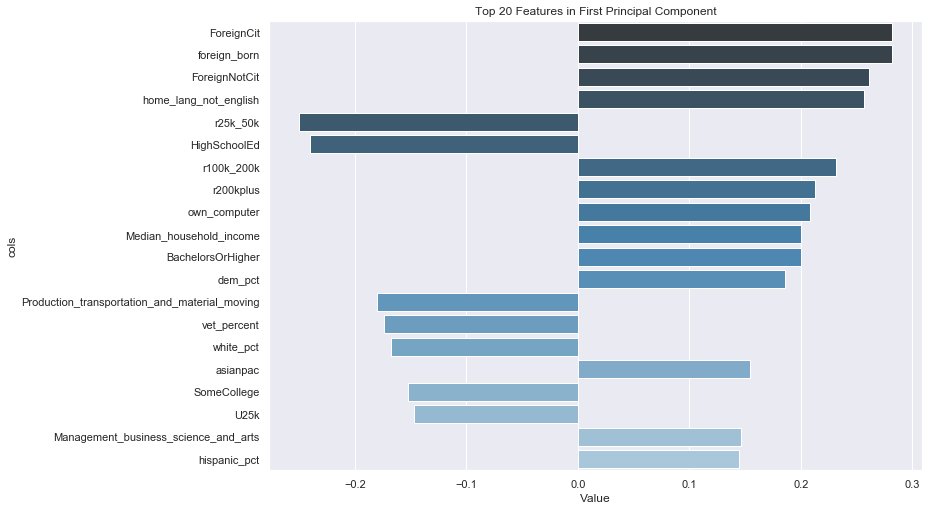

In [638]:
#Plot top 10 features in first principal component
pca_df0['abs_pca0']=pca_df0['pca0'].apply(lambda x: np.abs(x))
ax = sns.barplot(x='pca0', y='cols', palette="Blues_d", data=pca_df0.sort_values('abs_pca0', ascending=False).head(20))
ax.set_xlabel('Value')
ax.set_title('Top 20 Features in First Principal Component')
plt.show()

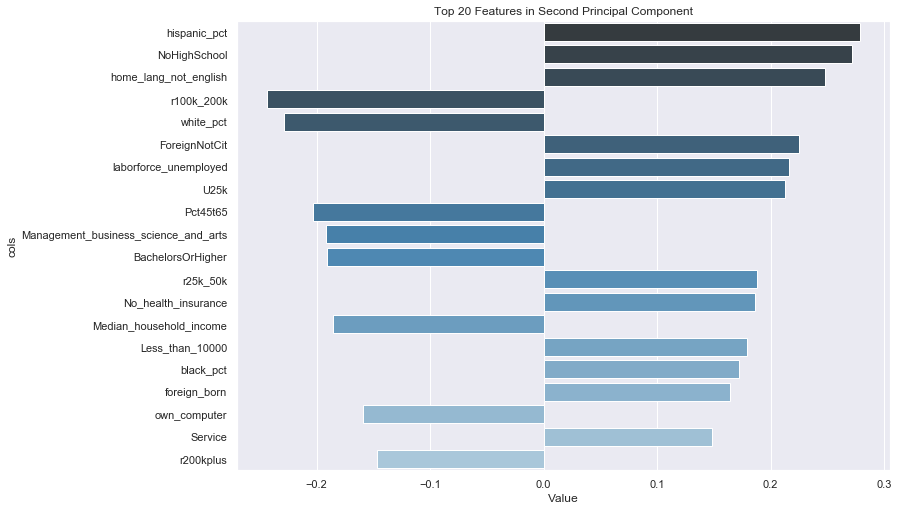

In [639]:
#Plot top 10 features in second principal component
pca_df1['abs_pca1']=pca_df1['pca1'].apply(lambda x: np.abs(x))
ax = sns.barplot(x='pca1', y='cols', palette="Blues_d", data=pca_df1.sort_values('abs_pca1', ascending=False).head(20))
ax.set_xlabel('Value')
ax.set_title('Top 20 Features in Second Principal Component')
plt.show()

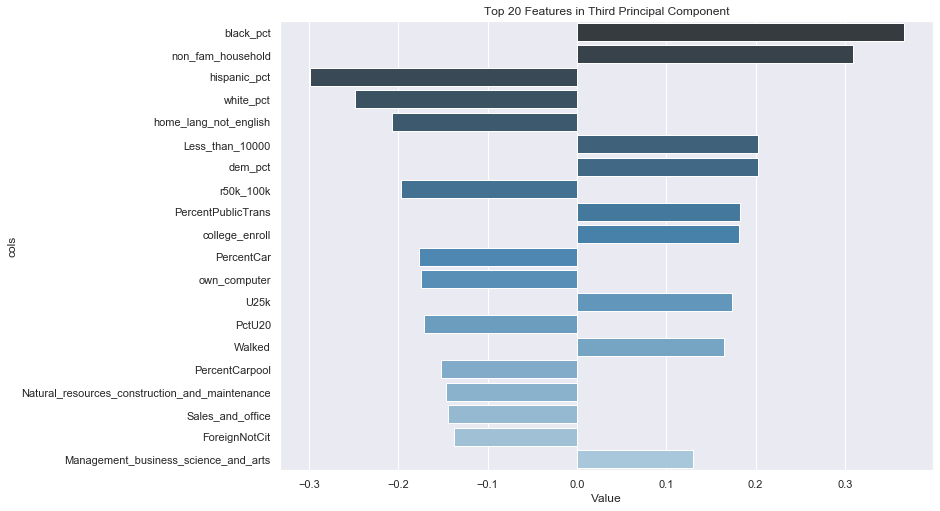

In [640]:
#Plot top 10 features in third principal component
pca_df2['abs_pca2']=pca_df2['pca2'].apply(lambda x: np.abs(x))
ax = sns.barplot(x='pca2', y='cols', palette="Blues_d", data=pca_df2.sort_values('abs_pca2', ascending=False).head(20))
ax.set_xlabel('Value')
ax.set_title('Top 20 Features in Third Principal Component')
plt.show()

## Comparison of clusters by features

After checking which features were most significantly contributing to the first few principal components, we can do a cluster comparison to see how the distribution of the top features changes in each cluster.

In [588]:
#Create dataframe for each of the four clusters
cluster0 = pd.DataFrame(data2[data2['cluster'] == 0])
cluster1 = pd.DataFrame(data2[data2['cluster'] == 1]) 
cluster2 = pd.DataFrame(data2[data2['cluster'] == 2]) 
cluster3 = pd.DataFrame(data2[data2['cluster'] == 3]) 

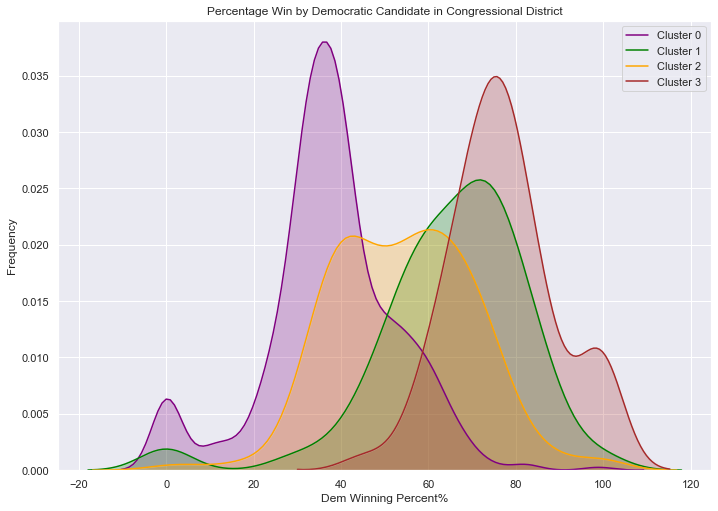

In [632]:
#Distribution of the vote percentage for the Democratic candidate 
ax1 = sns.kdeplot(cluster0['dem_pct'], shade=True, color="purple")
ax2 = sns.kdeplot(cluster1['dem_pct'], shade=True, color="green")
ax3 = sns.kdeplot(cluster2['dem_pct'], shade=True, color="orange")
ax4 = sns.kdeplot(cluster3['dem_pct'], shade=True, color="brown")
ax4.set(xlabel='Dem Winning Percent%', ylabel='Frequency')
ax4.set_title('Percentage Win by Democratic Candidate in Congressional District')
labels =['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
ax4.legend(labels)
plt.show()

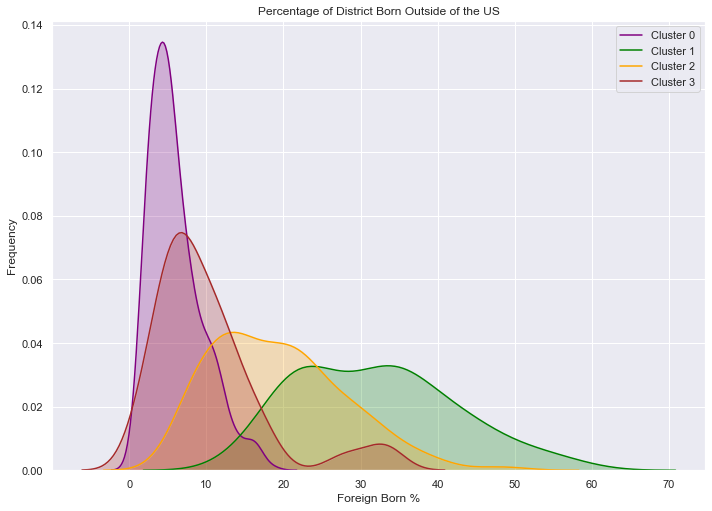

In [633]:
#Distribution of foreign born citizen percentage in each cluster
ax1 = sns.kdeplot(cluster0['foreign_born'], shade=True, color="purple")
ax2 = sns.kdeplot(cluster1['foreign_born'], shade=True, color="green")
ax3 = sns.kdeplot(cluster2['foreign_born'], shade=True, color="orange")
ax4 = sns.kdeplot(cluster3['foreign_born'], shade=True, color="brown")
ax4.set(xlabel='Foreign Born %', ylabel='Frequency')
ax4.set_title('Percentage of District Born Outside of the US')
labels =['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
ax4.legend(labels)
plt.show()

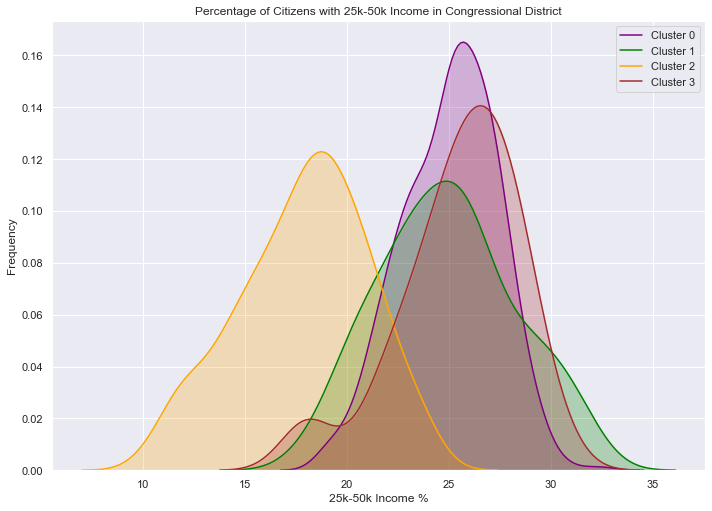

In [634]:
#Distribution of percentage of citizens with 25k-50k income in district
ax1 = sns.kdeplot(cluster0['r25k_50k'], shade=True, color="purple")
ax2 = sns.kdeplot(cluster1['r25k_50k'], shade=True, color="green")
ax3 = sns.kdeplot(cluster2['r25k_50k'], shade=True, color="orange")
ax4 = sns.kdeplot(cluster3['r25k_50k'], shade=True, color="brown")
ax4.set(xlabel='25k-50k Income %', ylabel='Frequency')
ax4.set_title('Percentage of Citizens with 25k-50k Income in Congressional District')
labels =['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
ax4.legend(labels)
plt.show()

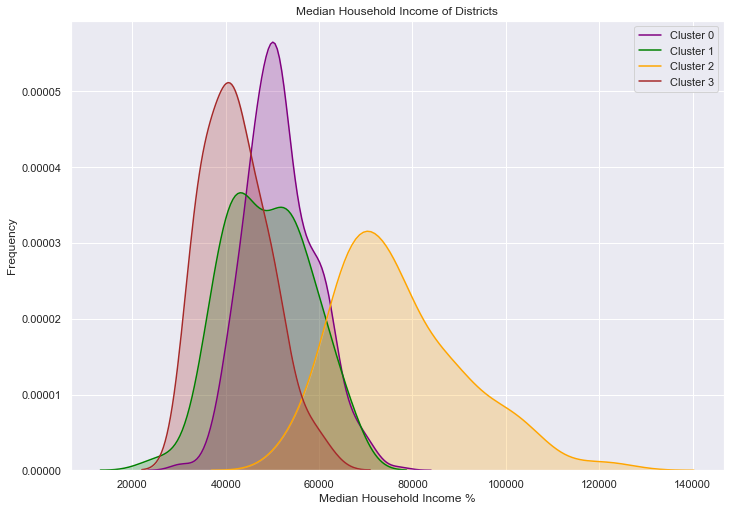

In [635]:
#Distribution of median household income in districts
ax1 = sns.kdeplot(cluster0['Median_household_income'], shade=True, color="purple")
ax2 = sns.kdeplot(cluster1['Median_household_income'], shade=True, color="green")
ax3 = sns.kdeplot(cluster2['Median_household_income'], shade=True, color="orange")
ax4 = sns.kdeplot(cluster3['Median_household_income'], shade=True, color="brown")
ax4.set(xlabel='Median Household Income %', ylabel='Frequency')
ax4.set_title('Median Household Income of Districts')
labels =['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
ax4.legend(labels)
plt.show()

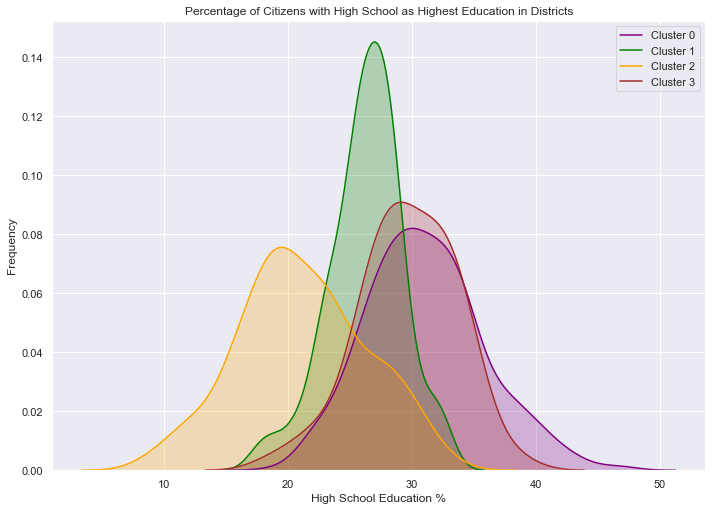

In [636]:
#Distribution of only achieving at most a high school education in districts
ax1 = sns.kdeplot(cluster0['HighSchoolEd'], shade=True, color="purple")
ax2 = sns.kdeplot(cluster1['HighSchoolEd'], shade=True, color="green")
ax3 = sns.kdeplot(cluster2['HighSchoolEd'], shade=True, color="orange")
ax4 = sns.kdeplot(cluster3['HighSchoolEd'], shade=True, color="brown")
ax4.set(xlabel='High School Education %', ylabel='Frequency')
ax4.set_title('Percentage of Citizens with High School as Highest Education in Districts')
labels =['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
ax4.legend(labels)
plt.show()

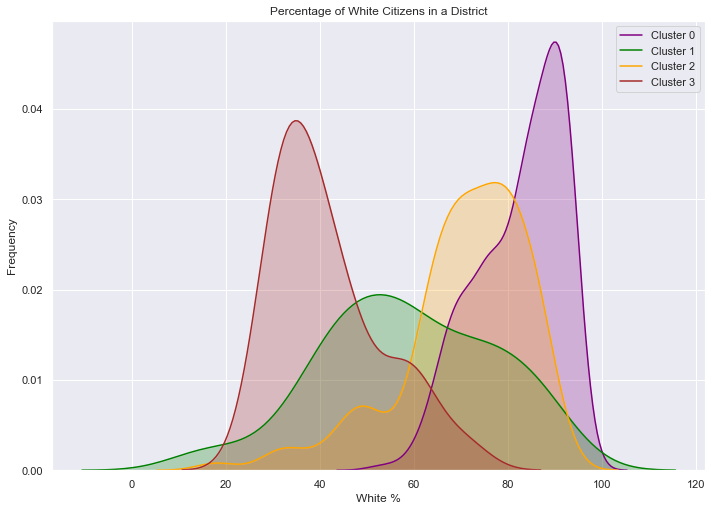

In [637]:
#Distribution of percentage of white people in a district
ax1 = sns.kdeplot(cluster0['white_pct'], shade=True, color="purple")
ax2 = sns.kdeplot(cluster1['white_pct'], shade=True, color="green")
ax3 = sns.kdeplot(cluster2['white_pct'], shade=True, color="orange")
ax4 = sns.kdeplot(cluster3['white_pct'], shade=True, color="brown")
ax4.set(xlabel='White %', ylabel='Frequency')
ax4.set_title('Percentage of White Citizens in a District')
labels =['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
ax4.legend(labels)
plt.show()